In [ ]:
%matplotlib inline

In [ ]:
%%capture
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
!pip install pydub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. 




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [ ]:
#CHECK ORIGINAL Train and Test Set Length
print(f"Train Length:{len(train_set)}")
print(f"Test  Length:{len( test_set)}")
print(train_set[0])

Train Length:84843
Test  Length:11005
(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]), 16000, 'backward', '0165e0e8', 0)


In [ ]:
%%capture
!wget https://www.cse.iitb.ac.in/~pjyothi/cs753/train_list.txt
!wget https://www.cse.iitb.ac.in/~pjyothi/cs753/test_list.txt
train_index = [int(val.rstrip('\n')) for val in open("train_list.txt").readlines()]
test_index  = [int(val.rstrip('\n')) for val in open( "test_list.txt").readlines()]

In [ ]:
#CHECK New Train and Test Set Length
train_set = [train_set[i] for i in train_index]
test_set  = [ test_set[i] for i in  test_index]
print(f"Train Length:{len(train_set)}")
print(f"Test  Length:{len(test_set)}")

Train Length:12000
Test  Length:4000


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


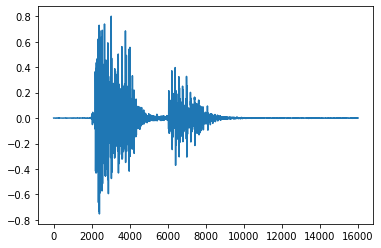

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(labels)
print(len(labels))

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
35


The 35 audio labels are commands that are said by users. 



In [ ]:
# CHECK sample_rate and sample_channel
sample_rates = set([datapoint[1] for datapoint in train_set])
sample_channels = set([datapoint[0].shape[0] for datapoint in train_set])
print(sample_rates)
print(sample_channels)

{16000}
{1}


ALL waveform.shape[0] is equal to 0 and wavefor.shape[1] <= 16000

First will say Backward and Last will say Zero

In [ ]:
#========== CHECK SAYING BACKWARD AND ZERO
display(ipd.Audio( train_set[0][0],  rate=sample_rate))
display(ipd.Audio(train_set[-1][0],  rate=sample_rate))


Formatting the Data
-------------------

For the waveform, we downsample the audio for faster processing without losing
too much of the classification power.
It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.


In [ ]:
train_i = None
for train_i, *_ in test_set:
  if(train_i.shape[1]!=16000):
    break

print(train_i.shape[1])

10923


In [ ]:
mfcc_transform = torchaudio.transforms.MFCC(n_mfcc=12, log_mels=True)
# Always DO .squeeze(0).transpose(0,1)

/usr/local/lib/python3.7/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([81, 12])
torch.Size([55, 12])


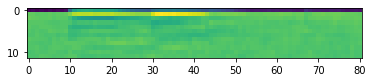

In [ ]:
wave_mfcc_i = mfcc_transform(train_i).squeeze(0).transpose(0,1)
wave_mfcc   = mfcc_transform(waveform).squeeze(0).transpose(0,1)

plt.imshow(wave_mfcc.transpose(0,1).numpy())

print(wave_mfcc.shape)
print(wave_mfcc_i.shape)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
  https://colab.research.google.com/  collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
mfcc_len = 12
hunits   = 400
layers   = 3

In [ ]:
class MyLSTM(torch.nn.Module):
  def __init__(self):
    super(MyLSTM, self).__init__()

    self.rnn = torch.nn.LSTM(input_size = mfcc_len, 
                              hidden_size= hunits, 
                              num_layers = layers, 
                              batch_first=True)
    self.out_layer = nn.Linear(hunits, len(labels))
  
  def forward(self, x):
    out, _ = self.rnn(x)
    x = self.out_layer(out[:,-1,:])
    return F.log_softmax(x, dim=1)


model = MyLSTM()
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

MyLSTM(
  (rnn): LSTM(12, 400, num_layers=3, batch_first=True)
  (out_layer): Linear(in_features=400, out_features=35, bias=True)
)
Number of parameters: 3242835


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = mfcc_transform(data).squeeze(1).permute(0, 2, 1)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = mfcc_transform(data).squeeze(1).permute(0, 2, 1)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({(100. * correct / len(test_loader.dataset)):.2f}%)\n")
    return correct, len(test_loader.dataset)

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
log_interval = 20
#============ UPDATING number of epochs ====================
n_epoch = 25

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
correct, total = None, None
mfcc_transform = mfcc_transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        correct, total = test(model, epoch)
        scheduler.step()


Train Epoch: 1 [0/12000 (0%)]	Loss: 3.558752
Train Epoch: 1 [5120/12000 (43%)]	Loss: 3.433558
Train Epoch: 1 [10240/12000 (85%)]	Loss: 3.284962

Test Epoch: 1	Accuracy: 300/4000 (7.50%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 3.173937
Train Epoch: 2 [5120/12000 (43%)]	Loss: 3.143561
Train Epoch: 2 [10240/12000 (85%)]	Loss: 3.142969

Test Epoch: 2	Accuracy: 547/4000 (13.68%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 2.813009
Train Epoch: 3 [5120/12000 (43%)]	Loss: 2.987490
Train Epoch: 3 [10240/12000 (85%)]	Loss: 2.623812

Test Epoch: 3	Accuracy: 891/4000 (22.27%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 2.693023
Train Epoch: 4 [5120/12000 (43%)]	Loss: 2.532324
Train Epoch: 4 [10240/12000 (85%)]	Loss: 2.546520

Test Epoch: 4	Accuracy: 1185/4000 (29.62%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 2.335964
Train Epoch: 5 [5120/12000 (43%)]	Loss: 2.308553
Train Epoch: 5 [10240/12000 (85%)]	Loss: 1.952334

Test Epoch: 5	Accuracy: 1575/4000 (39.38%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 2.070673
Train Epoch: 6

In [ ]:
# PRINT FINAL TEST ACCURACY
print(f"{(100. * correct / total):.2f}")

81.25
